In [1]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

/home/kmitchell/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Already processed features
train = pd.read_pickle('train_df.pkl')
test = pd.read_pickle('test_df.pkl')


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 23 columns):
bathrooms                49352 non-null float64
bedrooms                 49352 non-null int64
building_id              49352 non-null int64
created                  49352 non-null datetime64[ns]
description              49352 non-null object
display_address          49352 non-null int64
features                 49352 non-null object
interest_level           49352 non-null object
latitude                 49352 non-null float64
listing_id               49352 non-null int64
longitude                49352 non-null float64
manager_id               49352 non-null int64
photos                   49352 non-null object
price                    49352 non-null int64
street_address           49352 non-null int64
num_photos               49352 non-null int64
num_features             49352 non-null int64
num_description_words    49352 non-null int64
created_year             49352 non-null int

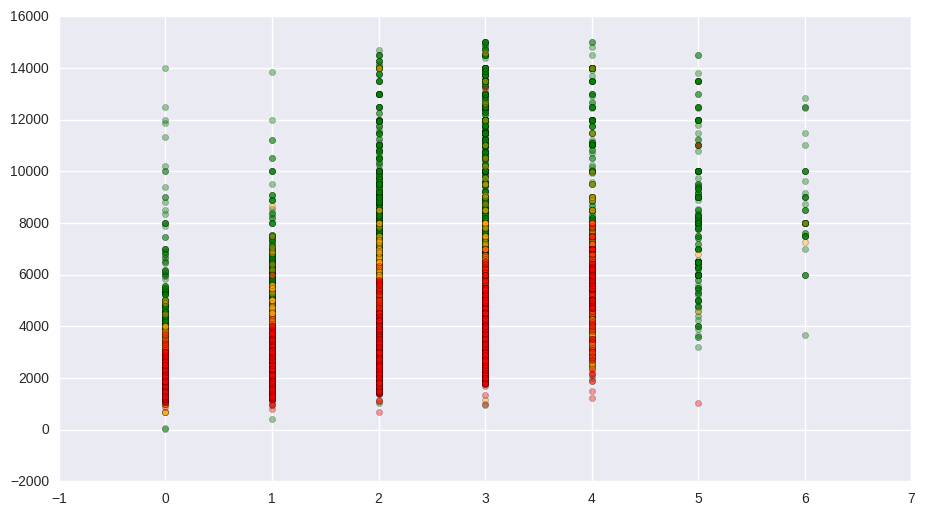

In [106]:
# limit number of bedrooms and prices
usable_train =  train[(train.price<15000) & (train.bedrooms<=6)]
palette = {"high": "r", "low":"g", "medium":"orange"}
plt.figure(figsize=(11,6))
for interest in ['low', 'medium', 'high']:
    plt.scatter(usable_train[usable_train.interest_level==interest].bedrooms, 
                usable_train[usable_train.interest_level==interest].price, 
                c=palette[interest],alpha=0.4)

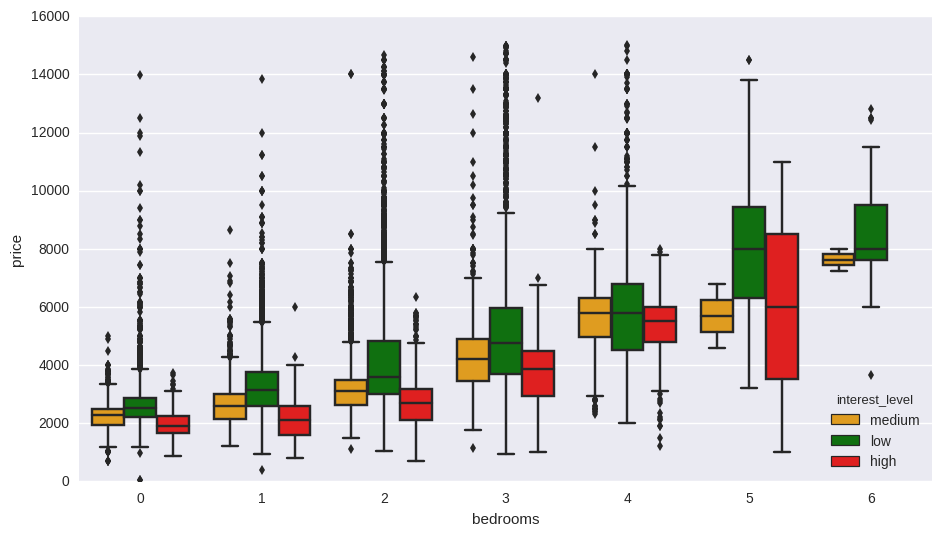

In [102]:
plt.figure(figsize=(11,6))
sns.boxplot(x="bedrooms", y="price", hue="interest_level", data=usable_train, palette=palette);

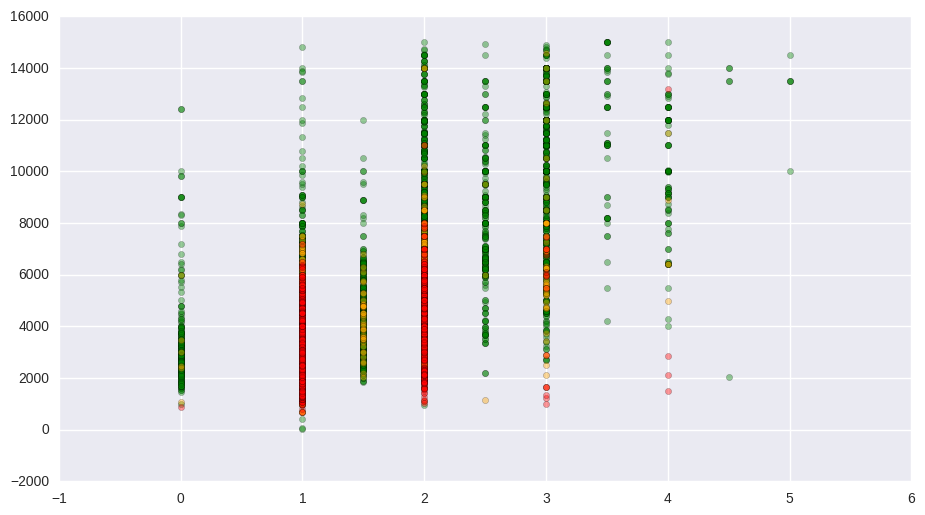

In [103]:
# limit number of bedrooms and prices
usable_train =  train[(train.price<15000) & (train.bathrooms<=6)]
palette = {"high": "r", "low":"g", "medium":"orange"}
plt.figure(figsize=(11,6))
for interest in ['low', 'medium', 'high']:
    plt.scatter(usable_train[usable_train.interest_level==interest].bathrooms, 
                usable_train[usable_train.interest_level==interest].price, 
                c=palette[interest],alpha=0.4)

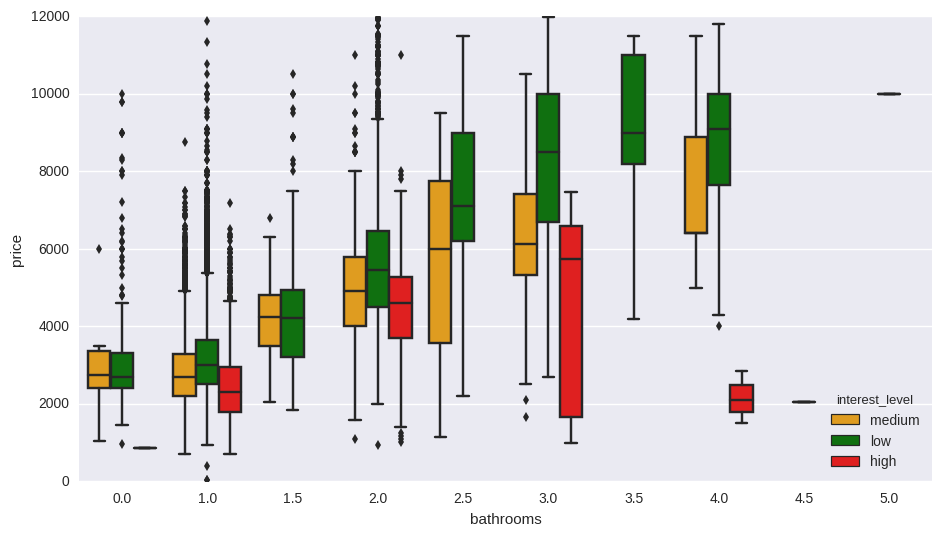

In [64]:
plt.figure(figsize=(11,6))
sns.boxplot(x="bathrooms", y="price", hue="interest_level", data=usable_train, palette=palette);

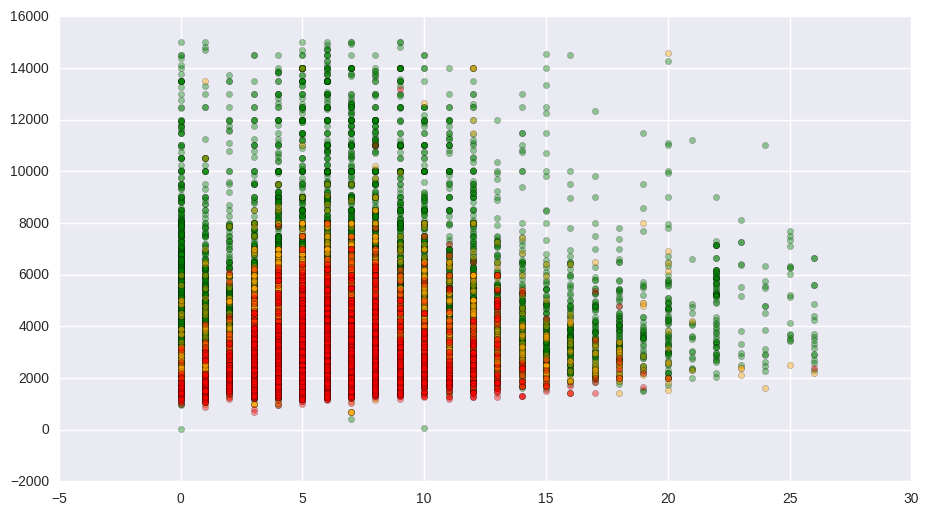

In [96]:
# limit number of photos and prices
photos_train =  train[(train.price<15000) & (train.num_photos< 27)]
palette = {"high": "r", "low":"g", "medium":"orange"}
plt.figure(figsize=(11,6))
for interest in ['low', 'medium', 'high']:
    plt.scatter(photos_train[photos_train.interest_level==interest].num_photos, 
                photos_train[photos_train.interest_level==interest].price, 
                c=palette[interest], alpha=0.4)

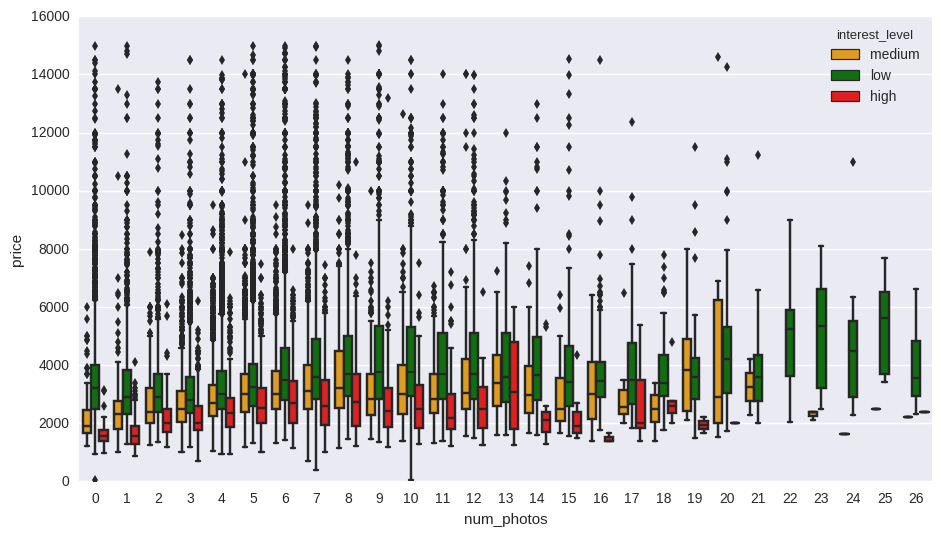

In [97]:
plt.figure(figsize=(11,6))
sns.boxplot(x="num_photos", y="price", hue="interest_level", data=photos_train, palette=palette);

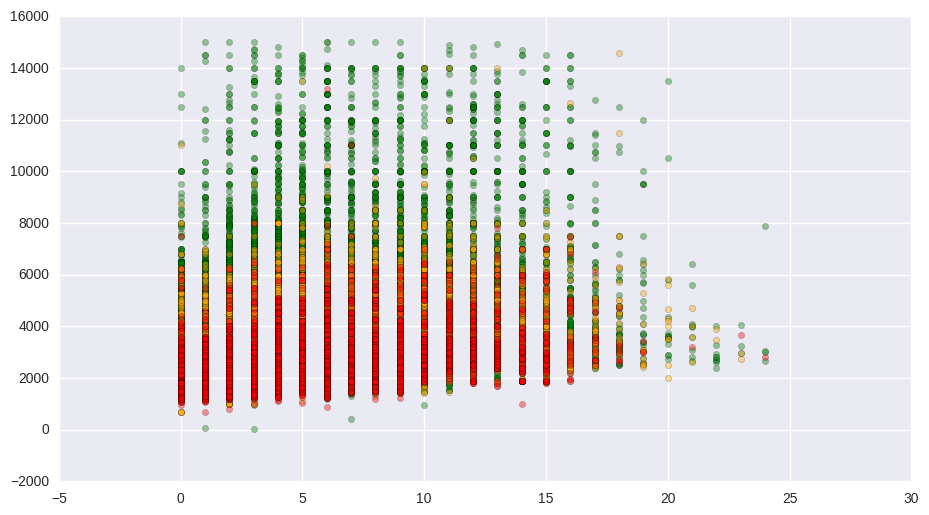

In [94]:
# limit number of features and prices
features_train =  train[(train.price<15000) & (train.num_features< 25)]
palette = {"high": "r", "low":"g", "medium":"orange"}
plt.figure(figsize=(11,6))
for interest in ['low', 'medium', 'high']:
    plt.scatter(features_train[features_train.interest_level==interest].num_features, 
                features_train[features_train.interest_level==interest].price, 
                c=palette[interest], alpha=0.4)

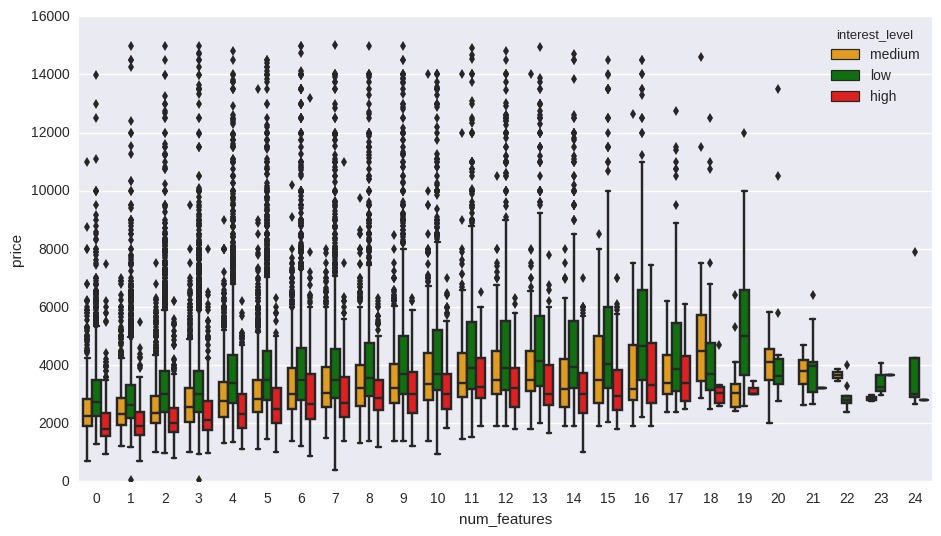

In [98]:
plt.figure(figsize=(11,6))
sns.boxplot(x="num_features", y="price", hue="interest_level", data=features_train, palette=palette);

In [86]:
print(min(train.created))
print(max(train.created))

2016-04-01 22:12:41
2016-06-29 21:41:47


/home/kmitchell/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


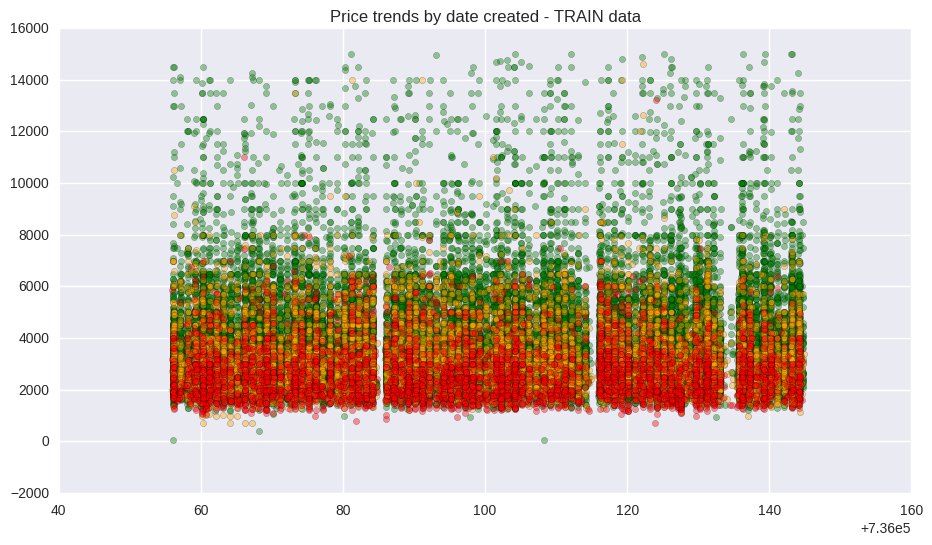

In [90]:
from matplotlib.dates import date2num
# limit number of prices
create_train =  train[(train.price<15000)                  
                     ]
palette = {"high": "r", "low":"g", "medium":"orange"}
plt.figure(figsize=(11,6))
create_train['created'] = [date2num(created) for (created) in create_train.created]

for interest in ['low', 'medium', 'high']:
    plt.scatter(create_train[create_train.interest_level==interest].created, 
    create_train[create_train.interest_level==interest].price, 
    c=palette[interest], alpha=0.4)
plt.title("Price trends by date created - TRAIN data");    

2016-04-01 22:23:31
2016-06-29 21:55:35


/home/kmitchell/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


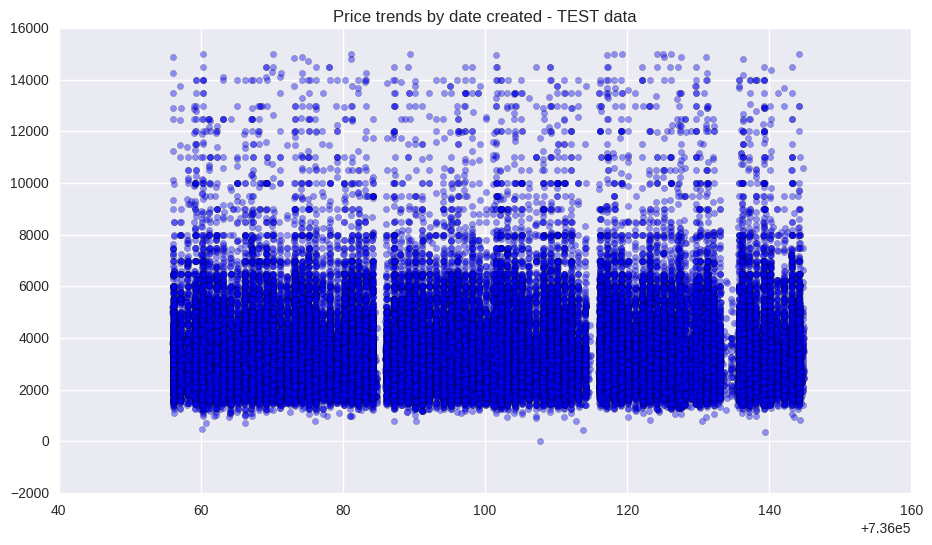

In [100]:
print(min(test.created))
print(max(test.created))
# limit number of prices
create_test =  test[(test.price<15000)]
palette = {"high": "r", "low":"g", "medium":"orange"}
plt.figure(figsize=(11,6))
create_test['created'] = [date2num(created) for (created) in create_test.created]
plt.scatter(create_test.created, create_test.price, alpha=0.4)

#for interest in ['low', 'medium', 'high']:
#    plt.scatter(create_test[create_test.interest_level==interest].created, 
#    create_test[create_test.interest_level==interest].price, 
#    c=palette[interest], alpha=0.4)
plt.title("Price trends by date created - TEST data");    

/home/kmitchell/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/kmitchell/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


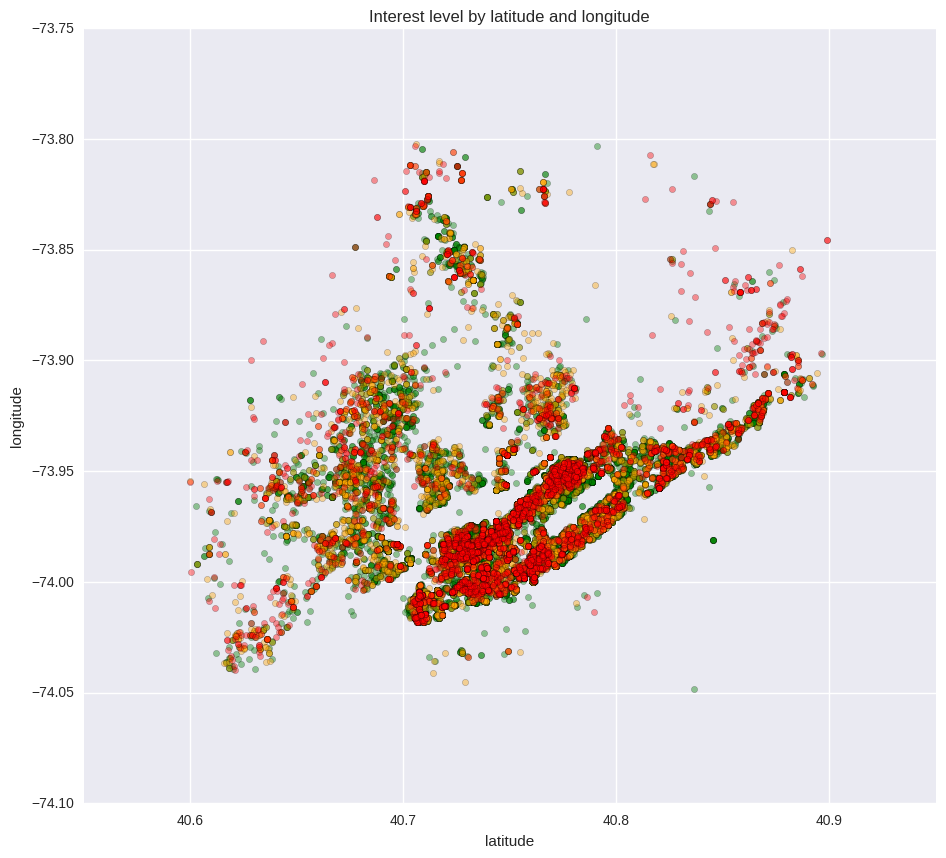

In [105]:
# limit latitude and longitude
latlong_train =  train[(train.latitude > 40.6) & (train.latitude < 40.9) & (train.longitude > -74.05) & (train.longitude < -73.8)]
palette = {"high": "r", "low":"g", "medium":"orange"}
plt.figure(figsize=(11,10))
for interest in ['low', 'medium', 'high']:
    plt.scatter(latlong_train[train.interest_level==interest].latitude, 
                latlong_train[train.interest_level==interest].longitude, 
                c=palette[interest], alpha=0.4)
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("Interest level by latitude and longitude");

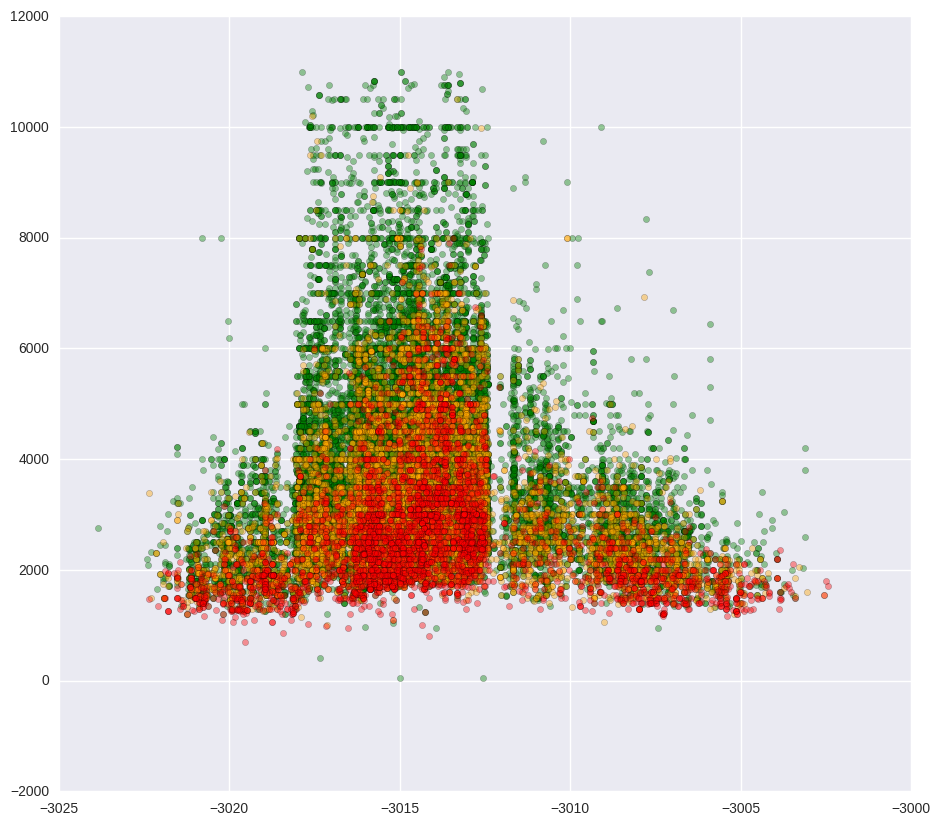

In [49]:
train["latlong"]=train.latitude * train.longitude
latlong_train =  train[(train.latitude > 40.6) & (train.latitude < 40.9) & 
                       (train.longitude > -74.05) & (train.longitude < -73.8)
                      & (train.price < 11000)]


palette = {"high": "r", "low":"g", "medium":"orange"}
plt.figure(figsize=(11,10))
for interest in ['low', 'medium', 'high']:
    plt.scatter(latlong_train[latlong_train.interest_level==interest].latlong, 
                latlong_train[latlong_train.interest_level==interest].price, 
                c=palette[interest], alpha=0.4)




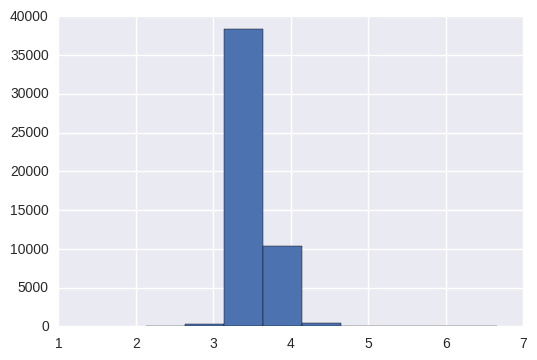

In [14]:
#plt.hist(train.price);
plt.hist(np.log10(train.price));
